# Produccion eléctrica en base a la metereología

La idea principal del trabajo es ser capaces de predecir como va a afectar a la produccion eléctrica de energias renovables y no renovables las precipitaciones, el viento y las horas de sol.
Como las horas de sol y el viento son fenomenos cuya causa efecto en principio es prácticamente inmediato, también vamos a centrarnos en la produccion de energia hidroelectrica para poder medir cuanto tiempo tarda en afectar a este tipo de energía las precipitaciones..

En base a esto tenemos varias cuestiones que queremos despejar:
- Que relación hay entre precipitaciones y el aumento de la generación de energia eléctrica hidráulica.
- Que relación hay entre horas de sol, temperatura y el aumento de la generación de energia eléctrica sólar.
- Que relación hay entre viento y el aumento de la generación de energia eléctrica eólica, esta relación esta condicionada por la temperatura, percipitaciones o horas de sol.
- Cuantos días tarda en aumentar la generación eléctrica de fuentes de energía renovables en función de los fenomenos metereológicos.
- Dados una prediccion meteorologica que valores de generación eléctrica tendremos para una fecha determinada.



Como premisas partimos de :
- Vamos a considerar solo el poll de energia que proporciona Red Electrica de España (REE)
- Vamos a considerar que las empresas no trabajan bajo mala praxis y que intentan optimizar el uso de energias renovables.
- Debido a la falta de datos a nivel diario de REE por provincia o comunidades autonomas, voy a centrar el analisis a nivel de sistema eléctrico (Peninsula, Baleares, Canarias ,Ceuta y Melilla).

Como origenes de datos para el estudio vamos a utilizar los datos proporcionados por:
- Información de REE (https://www.ree.es/es/apidatos) obtenida mediante su API.
- Datos proporcionados por aemet(https://opendata.aemet.es/centrodedescargas/inicio), vamos a utilizar la libreria  aemet desarrollada por Pablo Moreno (https://pypi.org/project/python-aemet/).

Requisitos para la ejecución del notebook:

Como requisitos para la ejecución del proyecto es necesario la instalación de la libreria python Aemet(pip install python-aemet) e instalar la libreria request.

Además las versiones de cada libreria utilizada en este proyecto son:

El modelo ha utilizar al tratarse de una prediccion númerica y no de obtener una etiqueta, sera una regresión.
Para poder llevar a cabo esa regresion se han pasado los valores de fechas a númericos, y se ha creado una columna por cada tipo de energia, creando varias variables objetivo.



In [2]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python

Mounted at /content/drive
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [3]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

     |████████████████████████████████| 409kB 6.7MB/s 


In [4]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Ing_AEMET=Ingestion_AEMET()

pd.options.display.max_columns=None
plt.style.use('ggplot')


# Reading DataFrames from pickle

In [5]:
df_ree=pd.read_pickle(Ing_AEMET.path_Data+"Ree_df.pkl")
df_weather_system=pd.read_pickle(Ing_AEMET.path_Data+"Weather_df.pkl")

In [6]:
df_ree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72354 entries, 0 to 703
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Generacion_Mwh  72354 non-null  float64
 1   Tecnologia      72354 non-null  object 
 2   Renov_norenov   72354 non-null  object 
 3   system          72354 non-null  object 
 4   fecha           72354 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.3+ MB


In [7]:
df_weather_system.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9840 entries, 0 to 9839
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     9840 non-null   object 
 1   system    9840 non-null   object 
 2   Holiday   9840 non-null   object 
 3   weekday   9840 non-null   object 
 4   tmin      9840 non-null   float64
 5   presMin   9840 non-null   float64
 6   prec      9840 non-null   float64
 7   tmed      9840 non-null   float64
 8   sol       9840 non-null   float64
 9   velmedia  9840 non-null   float64
 10  tmax      9840 non-null   float64
 11  presMax   9840 non-null   float64
 12  racha     9840 non-null   float64
dtypes: float64(9), object(4)
memory usage: 1.1+ MB


# Features 


In [8]:
df_ree=df_ree[df_ree['Renov_norenov']!='Generación total']
df_ree['Generacion_Mwh']=df_ree['Generacion_Mwh'].astype(float)

In [9]:
df_ree.reset_index(inplace=True,drop=True) #to join by index before encoding

In [10]:
df_weather_system['Holiday']=df_weather_system['Holiday'].astype(int)

## Encoder for categorical variables

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc=OneHotEncoder().fit(df_ree[['Tecnologia','system','Renov_norenov']])

df_transform=enc.transform(df_ree[['Tecnologia','system','Renov_norenov']])

df_onehot =  pd.DataFrame(df_transform.todense(), columns= enc.get_feature_names())

df_ree_onehot=pd.merge(df_ree[['Generacion_Mwh','fecha']],df_onehot,how='inner',left_index=True,right_index=True)

In [12]:
df_ree_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64890 entries, 0 to 64889
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Generacion_Mwh             64890 non-null  float64
 1   fecha                      64890 non-null  object 
 2   x0_Carbón                  64890 non-null  float64
 3   x0_Ciclo combinado         64890 non-null  float64
 4   x0_Cogeneración            64890 non-null  float64
 5   x0_Eólica                  64890 non-null  float64
 6   x0_Fuel + Gas              64890 non-null  float64
 7   x0_Hidroeólica             64890 non-null  float64
 8   x0_Hidráulica              64890 non-null  float64
 9   x0_Motores diésel          64890 non-null  float64
 10  x0_Nuclear                 64890 non-null  float64
 11  x0_Otras renovables        64890 non-null  float64
 12  x0_Residuos no renovables  64890 non-null  float64
 13  x0_Residuos renovables     64890 non-null  flo

In [13]:
tech_names=[x for x in enc.get_feature_names() if x[0:3]=='x0_']
system_names=[x for x in enc.get_feature_names() if x[0:3]=='x1_']
renov_names=[x for x in enc.get_feature_names() if x[0:3]=='x2_']

In [14]:

for column_tech in tech_names:
  df_ree_onehot[column_tech]=df_ree_onehot[column_tech]*df_ree_onehot['Generacion_Mwh']

for column_renov in renov_names:
  df_ree_onehot[column_renov]=(df_ree_onehot[column_renov]*df_ree_onehot['Generacion_Mwh'])

df_ree_target=df_ree_onehot.groupby(['fecha','x1_baleares','x1_canarias','x1_melilla','x1_peninsular'],as_index=False).sum()

for column_renov in renov_names:
  df_ree_target[column_renov]=(df_ree_target[column_renov]/df_ree_target['Generacion_Mwh'])

In [15]:
enc_system=OneHotEncoder().fit(df_weather_system[['system']])

df_transform_weather=enc_system.transform(df_weather_system[['system']])

column_weather=enc_system.get_feature_names(['x1'])

df_onehot_weather =  pd.DataFrame(df_transform_weather.todense(),columns=column_weather)

     
df_weather_features=pd.merge(df_weather_system,df_onehot_weather,left_index=True,right_index=True)                               
df_weather_features.drop('system',axis=1,inplace=True)
                               

In [16]:
df_weather_features.head()

,fecha,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,2016-01-01,1,4,3.300000,1009.300000,0.022222,13.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,1.0,0.0,0.0,0.0,0.0
1,2016-01-01,1,4,7.900000,894.700000,0.000000,18.040000,9.266667,2.781667,24.250000,1025.450000,10.400000,0.0,1.0,0.0,0.0,0.0
2,2016-01-01,1,4,13.800000,1012.400000,0.000000,17.500000,7.600000,1.400000,21.200000,1015.400000,10.800000,0.0,0.0,1.0,0.0,0.0
3,2016-01-01,1,4,10.600000,1016.600000,0.000000,15.500000,9.100000,1.700000,20.400000,1019.900000,5.600000,0.0,0.0,0.0,1.0,0.0
4,2016-01-01,1,4,3.817021,921.165957,5.477102,10.207533,2.231907,3.189763,16.440426,984.380851,16.361702,0.0,0.0,0.0,0.0,1.0


In [17]:
df_ree_target.head()

,fecha,x1_baleares,x1_canarias,x1_melilla,x1_peninsular,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x2_No-Renovable,x2_Renovable
0,2016-01-01,0.0,0.0,0.0,1.0,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.000,29281.000,0.000,162745.220,7169.124,3848.0700,1179.2320,8179.808,695.552,0.000,0.000,9782.273,0.542084,0.457916
1,2016-01-01,0.0,0.0,1.0,0.0,479.011,0.000,0.000,0.000,0.000,0.0,0.000,0.000,447.061,0.000,0.000,15.9025,15.9025,0.145,0.000,0.000,0.000,0.000,0.966499,0.033501
2,2016-01-01,0.0,1.0,0.0,0.0,20220.015,0.000,7124.185,0.000,383.526,0.0,11.815,9.163,6026.826,0.000,26.995,0.0000,0.0000,697.304,0.000,160.570,5779.631,0.000,0.944174,0.055826
3,2016-01-01,1.0,0.0,0.0,0.0,8814.678,3032.187,2277.467,69.160,11.053,0.0,0.000,0.000,1022.316,0.000,1.362,485.0490,485.0490,144.200,0.000,1286.835,0.000,0.000,0.927205,0.072795
4,2016-01-02,0.0,0.0,0.0,1.0,619096.702,28801.603,46225.570,53159.017,235393.376,0.0,0.000,35544.881,0.000,169614.296,7847.535,4097.2255,1139.0335,11752.604,1260.093,0.000,0.000,24261.468,0.526831,0.473169


##  Tratamiento de fechas

Para pasar las fechas aun formato en que el salto entre el ultimo dia de un mes y el primer dia del siguiente sea continuo, uso los cosenos de los dias y meses. 

Para ello situo los valores de los 31 dias en angulos iguales calulandolos como $Dia(x)=\cos\frac{2\pi}{31}x$

Para los meses situo cada mes en $Mes(x)=\cos\frac{2\pi}{12}x$

Y para los dias de la semana $Weekday(x)=\cos\frac{2\pi}{7}x$

In [18]:
# Para la columna de año, no quiero hacer un StandarScaler por que tendrian un mayor peso en el escalado los años completos.
# Además para los años futuros tendria en cuenta la media y desviacion de los datos de train, por lo que tendran mas peso del real.
# En lugar de eso para que la diferencia entre todos los años sea progresiva, hacer ln de year
df_weather_features['year']=np.log(df_weather_features['fecha'].str.slice(0,4).astype(int))
df_weather_features['day']=np.cos(((2*np.pi)/31)*df_weather_features['fecha'].str.slice(8,10).astype(int))
df_weather_features['month']=np.cos(((2*np.pi)/12)*df_weather_features['fecha'].str.slice(5,7).astype(int))
df_weather_features['weekday']=np.cos(((2*np.pi)/7)*df_weather_features['weekday'].astype(int))

## Correlation Matrix

In [19]:
Correlation_columns=['Holiday','weekday','year','day','month','tmin','tmed','tmax','prec','sol','velmedia','racha','presMax','presMin']
df_Matrix_Corr=df_weather_features[Correlation_columns].corr()

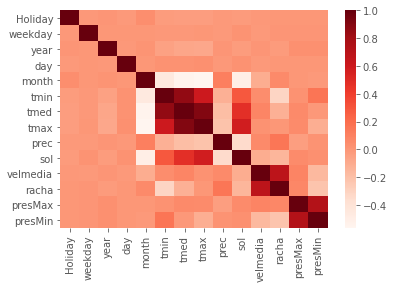

In [20]:
sns.heatmap(df_Matrix_Corr,cmap='Reds');

In [21]:
df_Matrix_Corr

,Holiday,weekday,year,day,month,tmin,tmed,tmax,prec,sol,velmedia,racha,presMax,presMin
Holiday,1.000000,-0.003574,0.008714,-0.009644,0.044325,-0.024911,-0.030201,-0.030836,-0.010730,-0.015520,-0.006785,0.002770,0.002058,0.000431
weekday,-0.003574,1.000000,-0.001149,0.000008,0.001026,-0.007613,-0.004972,-0.001341,-0.013938,0.018398,-0.010468,0.006070,0.009351,0.006890
year,0.008714,-0.001149,1.000000,-0.008389,0.010175,-0.050710,-0.072612,-0.079075,0.004941,-0.024757,0.008864,-0.016191,0.033749,0.028733
day,-0.009644,0.000008,-0.008389,1.000000,0.000446,0.022366,0.028063,0.029578,-0.003659,0.023127,-0.011490,-0.001862,-0.000399,-0.000320
month,0.044325,0.001026,0.010175,0.000446,1.000000,-0.453122,-0.545972,-0.564593,0.114505,-0.495095,-0.102894,0.063747,0.001293,-0.011568
tmin,-0.024911,-0.007613,-0.050710,0.022366,-0.453122,1.000000,0.862451,0.601505,-0.120437,0.291399,0.049925,-0.312446,0.023199,0.165757
tmed,-0.030201,-0.004972,-0.072612,0.028063,-0.545972,0.862451,1.000000,0.909684,-0.189608,0.476746,0.086098,-0.119583,0.063143,-0.003443
tmax,-0.030836,-0.001341,-0.079075,0.029578,-0.564593,0.601505,0.909684,1.000000,-0.212408,0.580304,0.026958,-0.001294,0.052905,-0.111445
prec,-0.010730,-0.013938,0.004941,-0.003659,0.114505,-0.120437,-0.189608,-0.212408,1.000000,-0.341059,0.063037,0.159837,-0.035019,0.018593
sol,-0.015520,0.018398,-0.024757,0.023127,-0.495095,0.291399,0.476746,0.580304,-0.341059,1.000000,-0.105448,-0.145324,0.057967,0.028386


## Unir las 2 tablas  df_weather_features, df_ree_target
To get only the features and targets of the same dates and systems

In [22]:
df_weather_ree=pd.merge(df_weather_features,
                            df_ree_target, 
                             on=['fecha','x1_baleares','x1_canarias','x1_melilla','x1_peninsular'])

In [23]:
features_list=['Holiday','weekday','tmin','presMin','prec','sol','tmed','tmax','presMax','racha','velmedia','year','day','month','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']
target_list=['Generacion_Mwh','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']

# Models

##Train-Test split

In [24]:
def train_test_val_split(df,features,targets,percentaje_test,percentaje_val):
  # Para no predecir con datos de futuro separo los datos en train y test por fecha
  
  total=len(df.index)
  row_test=np.round(total-(total*(percentaje_test+percentaje_val)),0).astype(np.int)
  row_val=np.round(total-(total*percentaje_val),0).astype(np.int)
  
  train=df.iloc[:row_test]
  test=df.iloc[row_test:row_val]
  val=df.iloc[row_val:]

  X_train=train[features_list]
  y_train=train[targets]

  X_test=test[features_list]
  y_test=test[targets]
  
  X_validation=val[features_list]
  y_validacion=val[targets]

  return X_train,X_test,y_train,y_test,X_validation,y_validacion

X_train,X_test,y_train,y_test,X_validation,y_validacion=train_test_val_split(df_weather_ree,
                                                                        features_list,
                                                                        target_list,
                                                                        .1,
                                                                        0)

##Scaler

In [25]:
from sklearn.preprocessing import StandardScaler

cols_scaler=['tmin','presMin','prec','sol','tmed','tmax','presMax','racha','velmedia']
scaler=StandardScaler().fit(X_train[cols_scaler])

X_train[cols_scaler]=scaler.transform(X_train[cols_scaler])
X_test[cols_scaler]=scaler.transform(X_test[cols_scaler])
X_train.head()

,Holiday,weekday,tmin,presMin,prec,sol,tmed,tmax,presMax,racha,velmedia,year,day,month,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,1,-0.900969,-1.136867,1.002234,-0.299936,-1.857531,-0.923110,-0.912791,0.990837,0.085514,-0.815171,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0
1,1,-0.900969,-0.428669,-1.207722,-0.305908,0.459953,-0.030671,-0.027933,1.023365,-0.660860,-0.509320,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0
2,1,-0.900969,-0.012987,1.143008,-0.305908,0.407235,-0.482424,-0.664699,0.695134,-1.603649,-1.306498,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.057269,-0.697350,1.165844,-1.765199,-1.423717,-1.319589,-1.405490,0.510103,-0.208558,7.608871,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.044494,0.946311,-0.305908,-1.477961,-0.822325,-0.615081,0.772017,1.872884,0.748885,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0


In [26]:
X_train

,Holiday,weekday,tmin,presMin,prec,sol,tmed,tmax,presMax,racha,velmedia,year,day,month,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,1,-0.900969,-1.136867,1.002234,-0.299936,-1.857531,-0.923110,-0.912791,0.990837,0.085514,-0.815171,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0
1,1,-0.900969,-0.428669,-1.207722,-0.305908,0.459953,-0.030671,-0.027933,1.023365,-0.660860,-0.509320,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0
2,1,-0.900969,-0.012987,1.143008,-0.305908,0.407235,-0.482424,-0.664699,0.695134,-1.603649,-1.306498,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.057269,-0.697350,1.165844,-1.765199,-1.423717,-1.319589,-1.405490,0.510103,-0.208558,7.608871,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.044494,0.946311,-0.305908,-1.477961,-0.822325,-0.615081,0.772017,1.872884,0.748885,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6702,0,0.623490,0.618234,1.121796,-0.305908,0.470496,0.140070,-0.185057,0.553197,-1.878629,-1.748691,7.610853,-0.994869,0.866025,0.0,0.0,0.0,1.0,0.0
6703,0,0.623490,-0.309434,-0.545047,0.198114,-1.416172,-0.576462,-0.589041,-1.522513,-0.317762,-0.460760,7.610853,-0.994869,0.866025,0.0,0.0,0.0,0.0,1.0
6704,0,1.000000,-0.259317,0.967523,-0.305908,-1.126859,-0.203784,0.096113,1.020407,0.733681,0.528607,7.610853,-0.994869,0.866025,1.0,0.0,0.0,0.0,0.0
6705,0,1.000000,0.556652,-1.214471,-0.305908,0.193727,0.943086,1.080207,0.766103,0.350673,-0.731646,7.610853,-0.994869,0.866025,0.0,1.0,0.0,0.0,0.0


##Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression


reg_ln=LinearRegression()

reg_ln.fit(X_train,y_train['Generacion_Mwh'])

y_pred_ln=reg_ln.predict(X_test)


##K-Neighbors

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

reg_KN=GridSearchCV(KNeighborsRegressor(),param_grid={"n_neighbors":np.arange(3,100)},scoring='neg_mean_squared_error')
reg_KN.fit(X_train,y_train['Generacion_Mwh'])
y_pred_KN=reg_KN.predict(X_test)
reg_KN.best_params_

{'n_neighbors': 14}

## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeRegressor

params_DT={'max_depth':range(3,50),'min_samples_leaf':range(1,5)}

reg_DT=GridSearchCV(DecisionTreeRegressor(),param_grid=params_DT,scoring='neg_mean_squared_error')
reg_DT.fit(X_train,y_train['Generacion_Mwh'])
y_pred_DT=reg_DT.predict(X_test)
reg_DT.best_params_

{'max_depth': 5, 'min_samples_leaf': 4}

##Boosting Models


###XGBoost

In [244]:
from xgboost import XGBRegressor,DMatrix

params_xgb={
    'max_depth':range(4,9),
    'n_estimators':range(50,90,2),
    'learning_rate':np.arange(.08,.14,.02),
    'min_split_loss':np.arange(0,.3,.1)
    }

reg_XGB=GridSearchCV(XGBRegressor(objective='reg:squarederror'),param_grid=params_xgb,scoring='neg_mean_squared_error')

reg_XGB.fit(X_train,y_train['Generacion_Mwh'])
y_pred_XGB=reg_XGB.predict(X_test)

print(reg_XGB.best_params_)
print(reg_XGB.best_estimator_)

KeyboardInterrupt: ignored

###LightGBM

In [ ]:
from lightgbm import LGBMRegressor

params_LGBM={
    'boosting_type':['gbdt','dart','goss','rf'],
    'max_depth':range(5,10),
    'n_estimators':range(60,120,2),
    'learning_rate':np.arange(.08,.14,.01),
    'min_split_gain':np.arange(0,.5,.1)
    }

reg_LGBM=GridSearchCV(LGBMRegressor(),param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(X_train,y_train['Generacion_Mwh'])
y_pred_LGBM=reg_LGBM.predict(X_test)

print(reg_LGBM.best_params_)
print(reg_LGBM.best_estimator_)


# Evaluation


## Evaluation function

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

def evaluation_function(y_real,y_pred,metrics,model):
  # Calculate de value por each metriz por y_real, y_pred then plot it por each model
  results={}
  results['Model_name']=[model]
  if 'MAE' in metrics:
    result_mae=mean_absolute_error(y_real,y_pred)
    results['MAE']=[result_mae]
  if 'RMSE' in metrics:
    result_rmse=mean_squared_error(y_real,y_pred,squared=False) 
    results['RMSE']=[result_rmse]
  return pd.DataFrame.from_dict(data=results)

def plot_metrics(df):

  fig, ax =plt.subplots(2,1)
  #MAE
  sns.barplot(y=df['Model_name'],x=df['MAE'],ax=ax[0]);
  ax[0].set_title("MAE Compare",fontsize=10)
  
  #RMSE
  sns.barplot(y=df['Model_name'],x=df['RMSE'],ax=ax[1]);
  ax[1].set_title("RMSE Compare",fontsize=10)

  return None


## Plot results funtion

In [ ]:
def plot_real_vs_pred(y_real,y_pred):
  f,ax=plt.subplots(1)
  f.set_size_inches(12,6)
  ax.plot(x=np.linspace(1,len(y_real)),y=y_real,c='g')
  ax.plot(x=np.linspace(1,len(y_pred)),y=y_pred,c='b')
  return None

y_pred_ln_peninsular=reg_ln.predict(X_test[X_test['x1_peninsular']==1])

#plot_real_vs_pred(y_test[y_test['x1_peninsular']==1]['Generacion_Mwh'],y_pred_ln_peninsular)

In [ ]:
y_pred_ln_peninsular.shape

In [ ]:
len(y_test[y_test['x1_peninsular']==1]['Generacion_Mwh'])

## Model choice

In [ ]:
pd_ln=evaluation_function(y_test['Generacion_Mwh'],y_pred_ln,['MAE','RMSE'],'LinearRegresion')
pd_kn=evaluation_function(y_test['Generacion_Mwh'],y_pred_KN,['MAE','RMSE'],'KN')
pd_DT=evaluation_function(y_test['Generacion_Mwh'],y_pred_DT,['MAE','RMSE'],'DT')
pd_XGB=evaluation_function(y_test['Generacion_Mwh'],y_pred_XGB,['MAE','RMSE'],'XGB')
pd_LGBM=evaluation_function(y_test['Generacion_Mwh'],y_pred_LGBM,['MAE','RMSE'],'LGBM')

pd_metrics=pd_ln.append(pd_kn)
pd_metrics=pd_metrics.append(pd_DT)
pd_metrics=pd_metrics.append(pd_XGB)
pd_metrics=pd_metrics.append(pd_LGBM)

plot_metrics(pd_metrics)

pd_metrics

## Overfitting

## The choosen one

Why?

In [ ]:
# export de pipeline of the model choosen

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

fechas-> preparar funcion o lambda
encoder -> ¿Como veo las columnas nuevas?
scaler -> pasar las columnas y un StandarScaler()
model

Para ejecutar.

Llamo a la funcion de train_test_split creada y ejecuto la pipeline?



from sklearn import set_config

set_config(display='diagram')
clf